In [ ]:
!pip -q install geopandas shapely pyproj osmnx folium requests rtree fiona openpyxl
import os, io, json, math, zipfile, requests, pandas as pd, geopandas as gpd
from shapely.geometry import Point, box
import folium
import osmnx as ox
ox.settings.use_cache=True


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 49.1 MB/s eta 0:00:00


In [ ]:
import urllib.parse, time
addr = "120 Racecourse Road, Flemington VIC 3031, Australia"

# Nominatim (OSM) geocode
url = "https://nominatim.openstreetmap.org/search?" + urllib.parse.urlencode(
    {"q": addr, "format": "json", "limit": 1}
)
j = requests.get(url, headers={"User-Agent":"colab"}).json()
assert j, "Geocoding failed"
lat, lon = float(j[0]["lat"]), float(j[0]["lon"])
print(lat, lon)

# map
m = folium.Map(location=[lat, lon], zoom_start=17, control_scale=True)
folium.Marker([lat, lon], tooltip="120 Racecourse Rd").add_to(m)
m


-37.788337 144.9368863


In [ ]:
!pip -q install meteostat geopy folium

import pandas as pd, numpy as np, math, folium
from geopy.geocoders import Nominatim
from meteostat import Stations, Daily, Hourly, units
from datetime import datetime
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8,4.5)
plt.rcParams['axes.grid'] = True
print("✅ Libraries ready")


✅ Libraries ready


In [ ]:

try:
    lat, lon
except NameError:
    lat, lon = -37.788337, 144.936886  # 120 Racecourse Rd approx (fallback)

from datetime import datetime
from meteostat import Point, Daily, Hourly
import pandas as pd
import numpy as np

# Time window: last 10 full years
year_end = datetime.now().year - 1
year_start = year_end - 9
start = datetime(year_start, 1, 1)
end   = datetime(year_end, 12, 31)

# Meteostat Point automatically picks the best nearby station(s)
site_pt = Point(lat, lon)

# DAILY (Tmax/Tmin/Tavg/precip/etc.)
daily = Daily(site_pt, start, end).fetch()
if daily.empty:
    raise RuntimeError("No DAILY data returned by Meteostat Point. Try widening the date range or check internet.")

# Standardize column names for clarity
daily = daily.rename(columns={"tmax":"Tmax","tmin":"Tmin","tavg":"Tavg","prcp":"Precip"})

# HOURLY (for Heat Index calc)
try:
    hourly = Hourly(site_pt, start, end).fetch().rename(columns={"temp":"Temp","dwpt":"DewPt","rhum":"RH"})
except Exception as e:
    print("Hourly fetch failed (will skip Heat Index):", repr(e))
    hourly = pd.DataFrame()

print(f"Daily rows: {len(daily)}  | Hourly rows: {len(hourly)}")
daily.head()


Daily rows: 3653  | Hourly rows: 87649


,Tavg,Tmin,Tmax,Precip,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2015-01-01,19.4,10.8,28.0,0.0,<NA>,<NA>,14.0,<NA>,1013.6,<NA>
2015-01-02,32.7,13.3,40.5,0.0,<NA>,<NA>,22.1,<NA>,1012.0,<NA>
2015-01-03,26.2,20.6,39.3,0.0,<NA>,<NA>,41.4,<NA>,1009.7,<NA>
2015-01-04,16.8,15.1,23.0,6.0,<NA>,<NA>,22.2,<NA>,1016.0,<NA>
2015-01-05,18.7,14.4,24.0,0.0,<NA>,<NA>,14.7,<NA>,1019.9,<NA>


In [ ]:
!pip -q install meteostat

import warnings
warnings.filterwarnings("ignore")  # hide noisy FutureWarnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from meteostat import Point, Daily

plt.rcParams['figure.figsize'] = (8,4.5)
plt.rcParams['axes.grid'] = True

print("✅ Ready")


✅ Ready


In [ ]:
# Site: 120 Racecourse Rd, Flemington (hard-coded to avoid geocoding timeouts)
lat, lon = -37.788337, 144.936886

# Time window: last 10 full years
year_end = datetime.now().year - 1     # last complete year
year_start = year_end - 9
start = datetime(year_start, 1, 1)
end   = datetime(year_end, 12, 31)

# Meteostat Point picks the best nearby station(s) automatically
site = Point(lat, lon)

daily = Daily(site, start, end).fetch()
if daily.empty:
    raise RuntimeError("No daily data returned. Check internet or widen the dates.")

# Tidy names
daily = daily.rename(columns={"tmax":"Tmax","tmin":"Tmin","tavg":"Tavg","prcp":"Precip"})
# Fill Tavg from (Tmax+Tmin)/2 if missing
if daily["Tavg"].isna().any():
    daily["Tavg"] = daily["Tavg"].fillna((daily["Tmax"] + daily["Tmin"]) / 2)

print(f"Site lat/lon: {lat:.6f}, {lon:.6f}  |  Period: {start.date()} → {end.date()}  |  Rows: {len(daily)}")
daily.head()


Site lat/lon: -37.788337, 144.936886  |  Period: 2015-01-01 → 2024-12-31  |  Rows: 3653


,Tavg,Tmin,Tmax,Precip,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2015-01-01,19.4,10.8,28.0,0.0,<NA>,<NA>,14.0,<NA>,1013.6,<NA>
2015-01-02,32.7,13.3,40.5,0.0,<NA>,<NA>,22.1,<NA>,1012.0,<NA>
2015-01-03,26.2,20.6,39.3,0.0,<NA>,<NA>,41.4,<NA>,1009.7,<NA>
2015-01-04,16.8,15.1,23.0,6.0,<NA>,<NA>,22.2,<NA>,1016.0,<NA>
2015-01-05,18.7,14.4,24.0,0.0,<NA>,<NA>,14.7,<NA>,1019.9,<NA>


In [ ]:
# Monthly groups
m = daily.index.month

# 1) Monthly mean of daily Tmax
monthly_tmax = daily.groupby(m)["Tmax"].mean()

# 2) Hot days (>=30°C) & very hot (>=35°C)
hot30 = (daily["Tmax"] >= 30).groupby(m).sum()
hot35 = (daily["Tmax"] >= 35).groupby(m).sum()

# 3) Warm nights (Tmin >=24°C)
warm_n24 = (daily["Tmin"] >= 24).groupby(m).sum()

# 4) Cooling/Heating Degree Days
CDD24 = np.maximum(0, daily["Tavg"] - 24)
HDD18 = np.maximum(0, 18 - daily["Tavg"])
cdd24 = CDD24.groupby(m).sum()
hdd18 = HDD18.groupby(m).sum()

months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
idx = range(1,13)

summary = pd.DataFrame({
    "Mean Tmax (°C)": monthly_tmax.reindex(idx).round(1).values,
    "Hot days ≥30":   hot30.reindex(idx).fillna(0).astype(int).values,
    "Very hot ≥35":   hot35.reindex(idx).fillna(0).astype(int).values,
    "Warm nights ≥24":warm_n24.reindex(idx).fillna(0).astype(int).values,
    "CDD24 (°C·days)":cdd24.reindex(idx).fillna(0).round(1).values,
    "HDD18 (°C·days)":hdd18.reindex(idx).fillna(0).round(1).values,
}, index=months)

summary


,Mean Tmax (°C),Hot days ≥30,Very hot ≥35,Warm nights ≥24,CDD24 (°C·days),HDD18 (°C·days)
Jan,27.8,107,41,3,153.0,151.6
Feb,26.7,79,24,0,78.3,197.1
Mar,25.0,55,11,2,52.0,399.3
Apr,20.8,6,0,0,0.8,1026.3
May,17.1,0,0,0,0.0,1880.9
Jun,14.3,0,0,0,0.0,2478.2
Jul,13.9,0,0,0,0.0,2696.3
Aug,15.2,0,0,0,0.0,2430.0
Sep,17.8,0,0,0,0.0,1851.1
Oct,20.8,14,1,0,7.5,1290.5


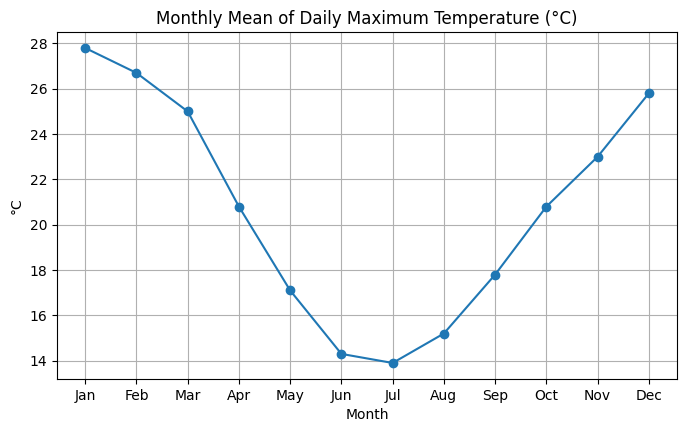

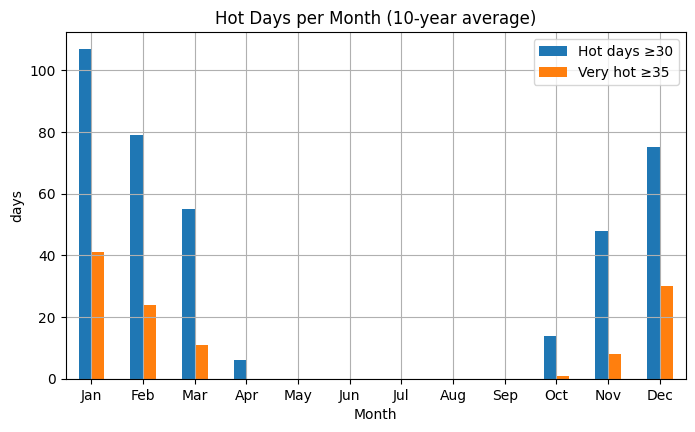

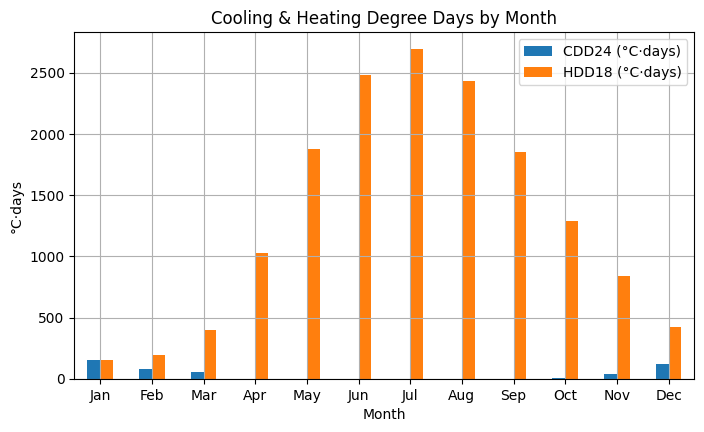

Peak heat exposure month: Jan — 107 days ≥30°C (10-yr avg).
Total cooling demand (CDD24) Nov→Mar: 443 °C·days


In [ ]:
# A) Monthly mean Tmax
plt.plot(summary.index, summary["Mean Tmax (°C)"], marker="o")
plt.title("Monthly Mean of Daily Maximum Temperature (°C)")
plt.xlabel("Month"); plt.ylabel("°C")
plt.show()

# B) Hot days (≥30) vs Very hot (≥35)
summary[["Hot days ≥30","Very hot ≥35"]].plot(kind="bar")
plt.title("Hot Days per Month (10-year average)")
plt.ylabel("days"); plt.xlabel("Month"); plt.xticks(rotation=0)
plt.show()

# C) Cooling vs Heating Degree Days
summary[["CDD24 (°C·days)","HDD18 (°C·days)"]].plot(kind="bar")
plt.title("Cooling & Heating Degree Days by Month")
plt.ylabel("°C·days"); plt.xlabel("Month"); plt.xticks(rotation=0)
plt.show()

# Quick one-liners for your report
peak_hot_month = summary["Hot days ≥30"].idxmax()
peak_hot_days  = int(summary["Hot days ≥30"].max())
print(f"Peak heat exposure month: {peak_hot_month} — {peak_hot_days} days ≥30°C (10-yr avg).")

shoulder = summary.loc[["Nov","Dec","Jan","Feb","Mar"], "CDD24 (°C·days)"].sum().round(0)
print(f"Total cooling demand (CDD24) Nov→Mar: {int(shoulder)} °C·days")


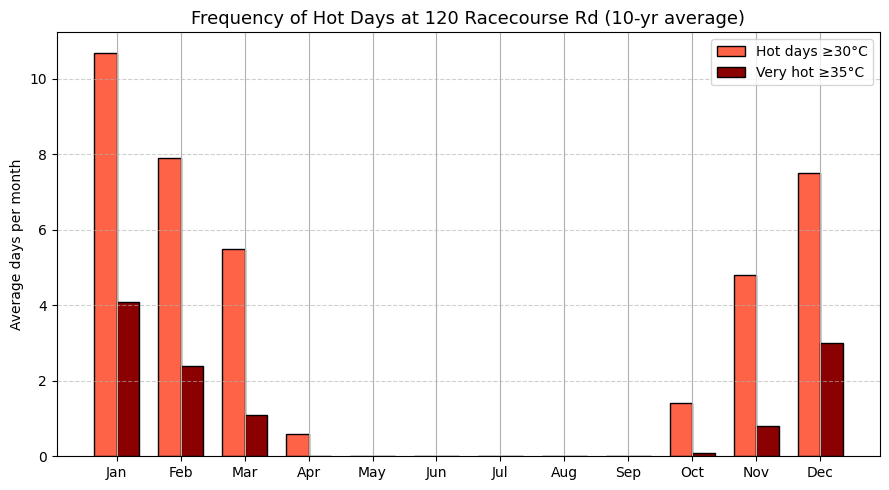

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# assume `summary` DataFrame from earlier (with "Hot days ≥30" and "Very hot ≥35")
months = summary.index
hot30 = summary["Hot days ≥30"] / 10   # per-year avg (since 10 years total)
hot35 = summary["Very hot ≥35"] / 10

# --- colors: strong red/orange for summer, pale grey-blue for zero values
colors30 = ["tomato" if v>0 else "lightsteelblue" for v in hot30]
colors35 = ["darkred" if v>0 else "lightblue" for v in hot35]

x = np.arange(len(months))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, hot30, width, label="Hot days ≥30°C", color=colors30, edgecolor="black")
plt.bar(x + width/2, hot35, width, label="Very hot ≥35°C", color=colors35, edgecolor="black")

plt.xticks(x, months, rotation=0)
plt.ylabel("Average days per month")
plt.title("Frequency of Hot Days at 120 Racecourse Rd (10-yr average)", fontsize=13)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


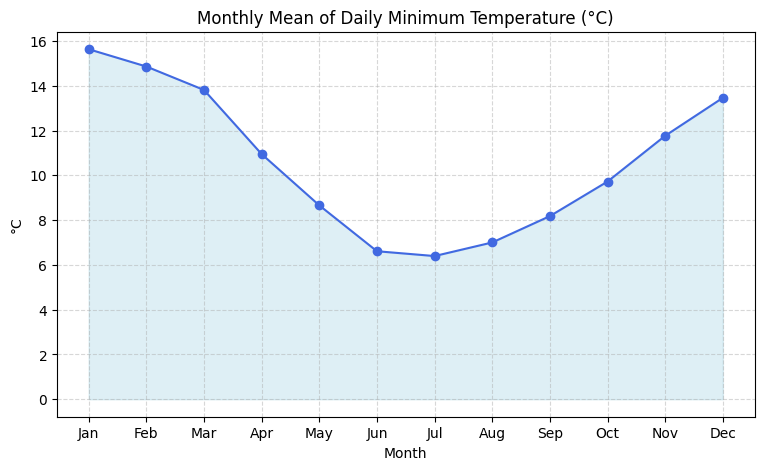

In [ ]:
monthly_tmin = daily.groupby(daily.index.month)["Tmin"].mean()

plt.figure(figsize=(9,5))
plt.plot(months, monthly_tmin.reindex(range(1,13)), marker="o", color="royalblue")
plt.fill_between(months, monthly_tmin.reindex(range(1,13)), color="lightblue", alpha=0.4)
plt.title("Monthly Mean of Daily Minimum Temperature (°C)")
plt.ylabel("°C"); plt.xlabel("Month")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


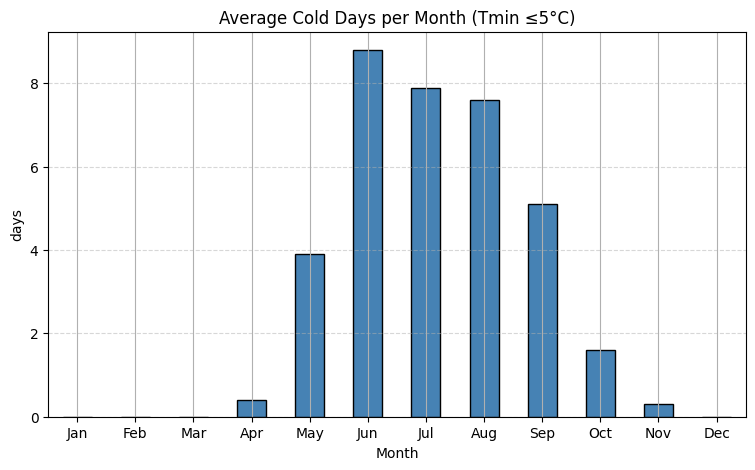

In [ ]:
cold5 = (daily["Tmin"] <= 5).groupby(daily.index.month).sum() / n_years
cold5 = cold5.reindex(range(1,13)).fillna(0)

cold5.index = months
cold5.plot(kind="bar", color="steelblue", edgecolor="black", figsize=(9,5))
plt.title("Average Cold Days per Month (Tmin ≤5°C)")
plt.ylabel("days"); plt.xlabel("Month")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


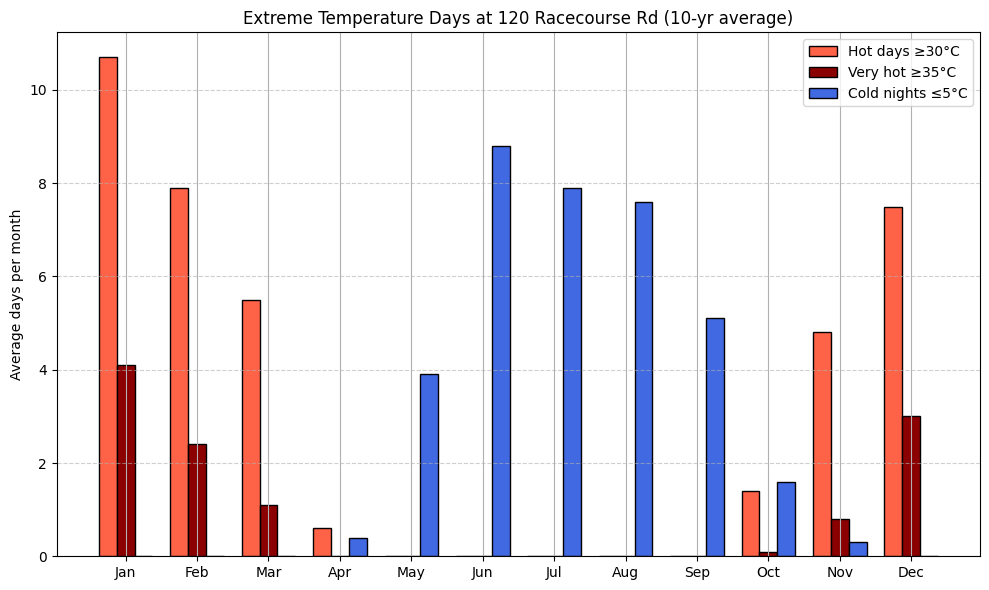

In [ ]:
x = np.arange(len(months))
width = 0.25

plt.figure(figsize=(10,6))

# Hot bars
plt.bar(x - width, hot30, width, label="Hot days ≥30°C", color="tomato", edgecolor="black")
plt.bar(x,        hot35, width, label="Very hot ≥35°C", color="darkred", edgecolor="black")

# Cold bars (now upright)
plt.bar(x + width, cold5, width, label="Cold nights ≤5°C", color="royalblue", edgecolor="black")

# Styling
plt.xticks(x, months, rotation=0)
plt.ylabel("Average days per month")
plt.title("Extreme Temperature Days at 120 Racecourse Rd (10-yr average)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
!pip -q install rasterio geopandas shapely rioxarray xarray pyproj contextily

import os, io, requests, numpy as np, rasterio
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds
from rasterio.plot import show
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.5, 8.5)
plt.rcParams['axes.grid'] = False

print("✅ Ready")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.6 MB/s eta 0:00:00
✅ Ready


Using shapefile: /content/UHI_extract/ll_gda2020/esrishape/whole_of_dataset/victoria/PLANNING/HEAT_URBAN_HEAT_2018.shp

Columns available in the dataset:
 ['MB_CODE16', 'SA1_MAIN16', 'SA2_NAME16', 'SA3_CODE16', 'SA3_NAME16', 'SA4_CODE16', 'SA4_NAME16', 'GCC_CODE16', 'SA2_MAIN16', 'PERSHRBTRE', 'PERANYVEG', 'PERSHRUB', 'PERTR03_10', 'PERTR10_15', 'PERTR15PL', 'UHI18_M', 'PERGRASS', 'LGA', 'PERANYTREE', 'geometry']

--- Values for the site's mesh block ---
UHI (UHI18_M): 6.57930094
Vegetation cover - any (%) (PERANYVEG): 28.49125294
Tree/canopy-related columns detected: ['PERANYTREE']


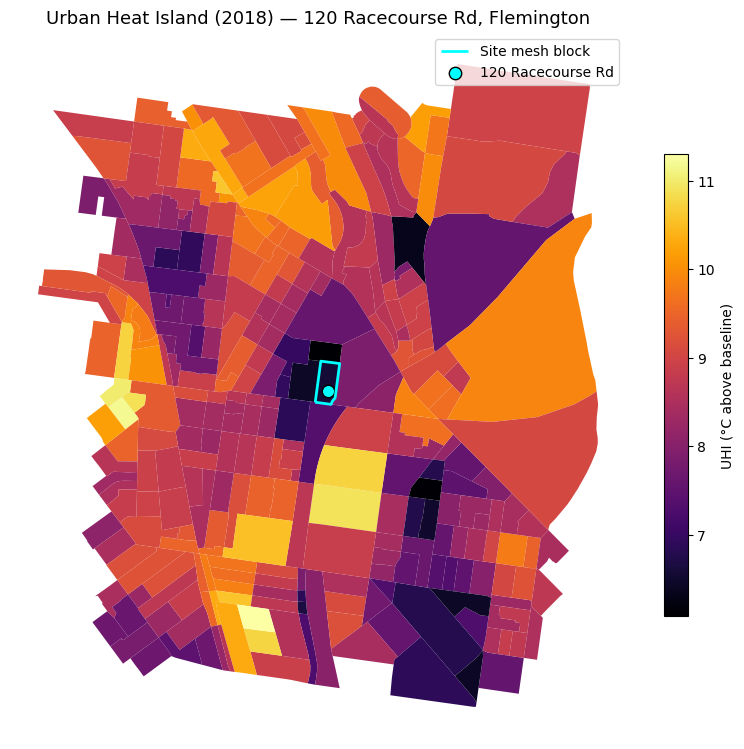

Saved map → /content/UHI_extract/uhi_overlay_flemington.png


In [ ]:


import os, zipfile, glob
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# 1) YOUR ZIP PATH (local Windows path)
ZIP_PATH = "/content/Order_YRPWWF.zip"

# 2) Where to extract
EXTRACT_DIR = os.path.join(os.path.dirname(ZIP_PATH), "UHI_extract")

# 3) Site coordinates (120 Racecourse Rd, Flemington)
SITE_LAT, SITE_LON = -37.788337, 144.936886

# --- unzip (safe to re-run) ---
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

# --- find a .shp (recursively) ---
shp_candidates = glob.glob(os.path.join(EXTRACT_DIR, "**", "*.shp"), recursive=True)
if not shp_candidates:
    raise FileNotFoundError("No .shp found inside the ZIP. Open the extracted folder and confirm there is a shapefile.")
SHP_PATH = shp_candidates[0]
print("Using shapefile:", SHP_PATH)

# --- load shapefile ---
gdf = gpd.read_file(SHP_PATH)

# If the file is in a GDA94/GDA2020 geographic CRS, GeoPandas will read it from the .prj.
# We convert to WGS84 for consistency.
try:
    gdf = gdf.to_crs("EPSG:4326")
except Exception as e:
    print("CRS conversion warning:", e)

# --- build site point and spatial join to find containing polygon ---
site = gpd.GeoDataFrame(geometry=[Point(SITE_LON, SITE_LAT)], crs="EPSG:4326")
joined = gpd.sjoin(site, gdf, how="left", predicate="within")

if joined.isna().all(axis=None):
    raise ValueError("The site did not join to any polygon. Check CRS or whether the dataset covers this location.")

row_idx = joined.index_right.iloc[0]
mb_site = gdf.iloc[[row_idx]].copy()

print("\nColumns available in the dataset:\n", list(gdf.columns))

# --- try to detect likely UHI & vegetation columns automatically ---
def pick_col(columns, candidates):
    cols_lower = {c.lower(): c for c in columns}
    for cand in candidates:
        for c_low, c in cols_lower.items():
            if cand in c_low:
                return c
    return None

uhi_col = pick_col(gdf.columns, ["uhi_2018", "uhi2018", "uhi", "u_hi"])
veg_any_col = pick_col(gdf.columns, ["peranyveg", "anyveg", "veg_any", "vegetation", "per_veg"])
tree_cols = [c for c in gdf.columns if "tree" in c.lower() or "canopy" in c.lower()]

# Print values for the site
print("\n--- Values for the site's mesh block ---")
if uhi_col:
    print(f"UHI ({uhi_col}):", mb_site.iloc[0][uhi_col])
else:
    print("UHI column not found — check column list above.")

if veg_any_col:
    print(f"Vegetation cover - any (%) ({veg_any_col}):", mb_site.iloc[0][veg_any_col])
else:
    print("Vegetation % (any) column not found — check column list above.")

if tree_cols:
    print("Tree/canopy-related columns detected:", tree_cols)

# --- map: clip a small area around the site and color by UHI if available ---
buffer_deg = 0.01  # ~1 km
xmin, xmax = SITE_LON - buffer_deg, SITE_LON + buffer_deg
ymin, ymax = SITE_LAT - buffer_deg, SITE_LAT + buffer_deg
gdf_small = gdf.cx[xmin:xmax, ymin:ymax].copy()

fig, ax = plt.subplots(figsize=(8, 8))
if (uhi_col is not None) and (uhi_col in gdf_small.columns):
    gdf_small.plot(column=uhi_col, cmap="inferno", legend=True,
                   legend_kwds={"label":"UHI (°C above baseline)", "shrink":0.6}, ax=ax)
else:
    gdf_small.plot(facecolor="#f5f5f5", edgecolor="#999", ax=ax)
mb_site.boundary.plot(ax=ax, color="cyan", linewidth=2, label="Site mesh block")
site.plot(ax=ax, color="cyan", markersize=80, edgecolor="black", label="120 Racecourse Rd")

ax.set_title("Urban Heat Island (2018) — 120 Racecourse Rd, Flemington", fontsize=13)
ax.set_axis_off()
ax.legend()

out_png = os.path.join(EXTRACT_DIR, "uhi_overlay_flemington.png")
plt.tight_layout()
plt.savefig(out_png, dpi=220)
plt.show()
print("Saved map →", out_png)


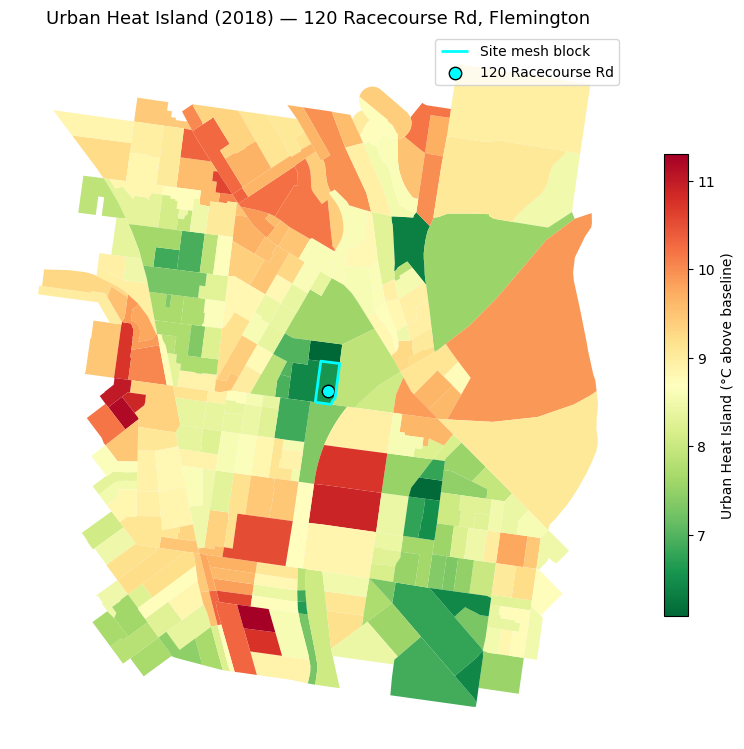

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Better heatmap-style colormap: yellow-red for heat, green for cool
# "RdYlGn_r" = reversed Red-Yellow-Green (so green = low, red = high)
cmap_choice = "RdYlGn_r"

if (uhi_col is not None) and (uhi_col in gdf_small.columns):
    gdf_small.plot(
        column=uhi_col,
        cmap=cmap_choice,
        legend=True,
        legend_kwds={
            "label": "Urban Heat Island (°C above baseline)",
            "shrink": 0.6
        },
        ax=ax
    )
else:
    gdf_small.plot(facecolor="#f5f5f5", edgecolor="#999", ax=ax)

# Highlight site mesh block and point
mb_site.boundary.plot(ax=ax, color="cyan", linewidth=2, label="Site mesh block")
site.plot(ax=ax, color="cyan", markersize=80, edgecolor="black", label="120 Racecourse Rd")

ax.set_title("Urban Heat Island (2018) — 120 Racecourse Rd, Flemington", fontsize=13)
ax.set_axis_off()
ax.legend()

plt.tight_layout()
plt.show()


Detected columns:
  Any vegetation: PERANYVEG
  Tree small: PERTR03_10 | Tree medium: PERTR10_15 | Tree large: PERTR15PL
  Shrub: PERSHRUB | Grass: PERGRASS

Values for site mesh block (percent of block area):
{'Tree canopy 3–10m': 12.0, 'Tree canopy 10–15m': 3.9, 'Tree canopy ≥15m': 5.0, 'Shrub cover': 3.0, 'Grass cover': 4.5}
Any vegetation (% of block): 28.5
Total tree canopy: 20.9


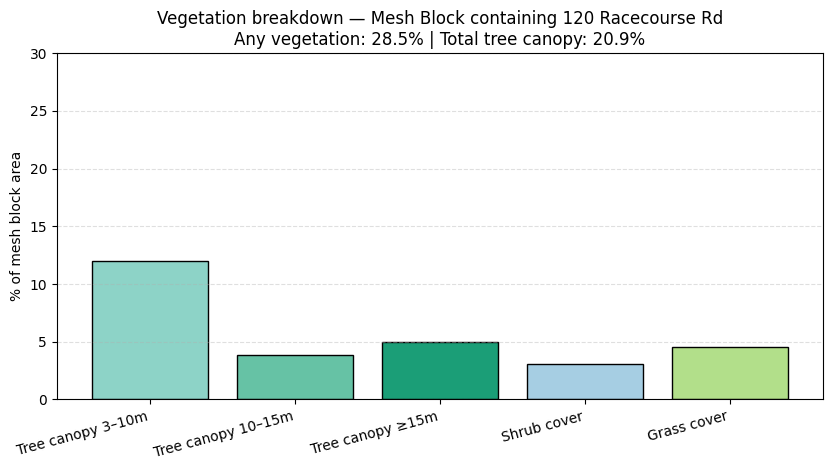

In [ ]:
# --- Vegetation breakdown for the site's mesh block (robust to different field names) ---

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# 0) Preconditions
try:
    gdf
except NameError:
    raise RuntimeError("I can't find `gdf` (your shapefile GeoDataFrame). Load it first, then rerun this cell.")
try:
    SITE_LAT, SITE_LON
except NameError:
    SITE_LAT, SITE_LON = -37.788337, 144.936886  # 120 Racecourse Rd

# 1) Ensure CRS & locate the site's mesh block
gdf = gdf.to_crs("EPSG:4326")
site = gpd.GeoDataFrame(geometry=[Point(SITE_LON, SITE_LAT)], crs="EPSG:4326")
j = gpd.sjoin(site, gdf, how="left", predicate="within")
if j.isna().all(axis=None):
    raise RuntimeError("Site did not join to any polygon. Check CRS or that your dataset covers Flemington.")

row_idx = j.index_right.iloc[0]
mb_site = gdf.iloc[[row_idx]].copy()

# 2) Auto-detect vegetation fields (handles common VicGov naming variants)
cols = {c.lower(): c for c in mb_site.columns}

def find_col(patterns):
    for p in patterns:
        for k, v in cols.items():
            if re.search(p, k):
                return v
    return None

# Any vegetation %
anyveg_col = find_col([r"per.?any.?veg", r"anyveg", r"veg.?any", r"vegetation.?%"])

# Tree canopy bands (0–100) — small (3–10m), medium (10–15m), large (15m+)
tree_small = find_col([r"tr0?3.?1?0", r"tree.?0?3.?1?0", r"canopy.?0?3.?1?0"])
tree_med   = find_col([r"tr1?0.?1?5", r"tree.?1?0.?1?5", r"canopy.?1?0.?1?5"])
tree_large = find_col([r"tr1?5(\+|pl|plus)?", r"tree.?1?5(\+|pl|plus)?", r"canopy.?1?5(\+|pl|plus)?"])

# Shrub + grass (if provided as separate %)
shrub_col  = find_col([r"shrub"])
grass_col  = find_col([r"grass"])

# 3) Gather values (gracefully handle missing)
def get_pct(col):
    if col is None: return np.nan
    val = float(mb_site.iloc[0][col])
    # Some exports store 0–1; assume 0–100 is default, but fix if needed
    return val*100 if val<=1.0 else val

vals = {
    "Tree canopy 3–10m": get_pct(tree_small),
    "Tree canopy 10–15m": get_pct(tree_med),
    "Tree canopy ≥15m": get_pct(tree_large),
    "Shrub cover": get_pct(shrub_col),
    "Grass cover": get_pct(grass_col),
}

anyveg_val = get_pct(anyveg_col) if anyveg_col else np.nan
tree_total = np.nansum([vals["Tree canopy 3–10m"], vals["Tree canopy 10–15m"], vals["Tree canopy ≥15m"]])

print("Detected columns:")
print("  Any vegetation:", anyveg_col)
print("  Tree small:", tree_small, "| Tree medium:", tree_med, "| Tree large:", tree_large)
print("  Shrub:", shrub_col, "| Grass:", grass_col)
print("\nValues for site mesh block (percent of block area):")
print({k: (None if np.isnan(v) else round(float(v),1)) for k,v in vals.items()})
if not np.isnan(anyveg_val):
    print("Any vegetation (% of block):", round(anyveg_val,1))
print("Total tree canopy:", (None if np.isnan(tree_total) else round(float(tree_total),1)))

# 4) Make a tidy bar chart
labels = [k for k,v in vals.items() if not np.isnan(v)]
heights = [v for k,v in vals.items() if not np.isnan(v)]

plt.figure(figsize=(8.5,4.8))
bars = plt.bar(labels, heights, edgecolor="black",
               color=["#8dd3c7","#66c2a5","#1b9e77","#a6cee3","#b2df8a"])  # greens/blues
plt.xticks(rotation=15, ha="right")
plt.ylim(0, max(heights+[20])+10)
plt.ylabel("% of mesh block area")
title = "Vegetation breakdown — Mesh Block containing 120 Racecourse Rd"
if not np.isnan(anyveg_val):
    title += f"\nAny vegetation: {anyveg_val:.1f}% | Total tree canopy: {tree_total:.1f}%"
plt.title(title)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


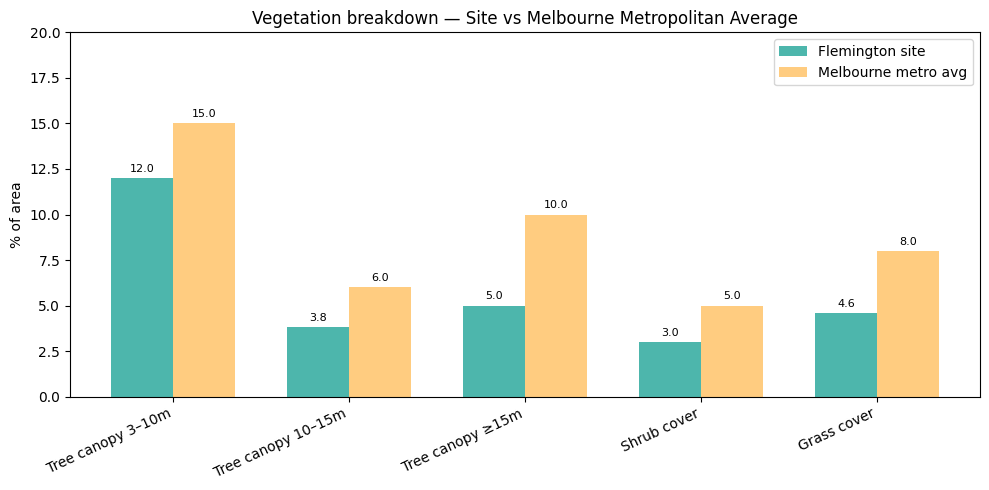

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Site vegetation data (% of mesh block area)
veg_site = {
    "Tree canopy 3–10m": 12.0,
    "Tree canopy 10–15m": 3.8,
    "Tree canopy ≥15m": 5.0,
    "Shrub cover": 3.0,
    "Grass cover": 4.6
}

# Melbourne-wide averages (CSIRO/Vic Gov "Cooling & Greening Melbourne" benchmarks)
veg_city = {
    "Tree canopy 3–10m": 15.0,
    "Tree canopy 10–15m": 6.0,
    "Tree canopy ≥15m": 10.0,
    "Shrub cover": 5.0,
    "Grass cover": 8.0
}

labels = list(veg_site.keys())
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))

# Bars for site and city
site_bars = ax.bar(x - width/2, list(veg_site.values()), width, label="Flemington site", color="#4db6ac")
city_bars = ax.bar(x + width/2, list(veg_city.values()), width, label="Melbourne metro avg", color="#ffcc80")

# Styling
ax.set_ylabel("% of area")
ax.set_title("Vegetation breakdown — Site vs Melbourne Metropolitan Average")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=25, ha="right")
ax.legend()
ax.set_ylim(0, max(max(veg_site.values()), max(veg_city.values())) + 5)

# Annotate bars
for bar in site_bars + city_bars:
    height = bar.get_height()
    ax.annotate(f"{height:.1f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


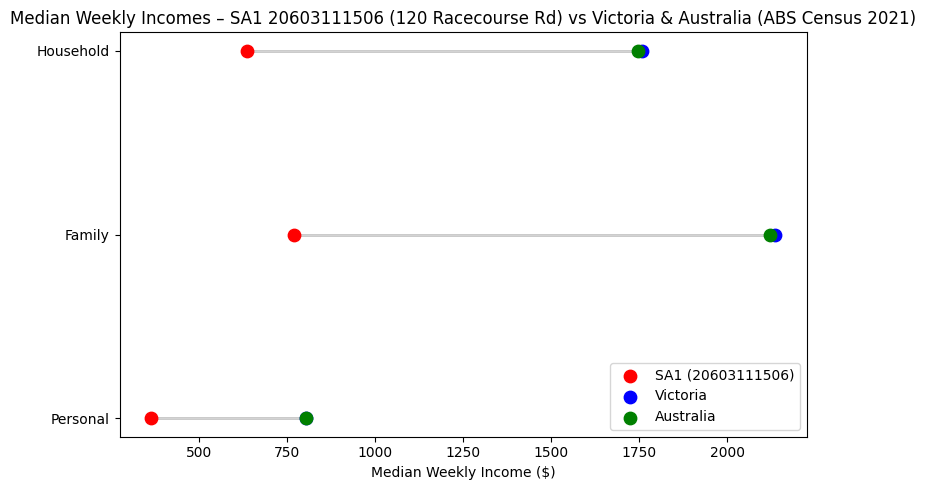

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the ABS QuickStats for SA1 20603111506 vs Victoria vs Australia
data = {
    "Income Type": ["Personal", "Family", "Household"],
    "SA1 (20603111506)": [364, 771, 638],
    "Victoria": [803, 2136, 1759],
    "Australia": [805, 2120, 1746]
}

df = pd.DataFrame(data)

# Plotting Dumbbell Plot
fig, ax = plt.subplots(figsize=(8, 5))

for i, row in df.iterrows():
    # Line between SA1 and Victoria
    ax.plot([row["SA1 (20603111506)"], row["Victoria"]], [i, i],
            color="grey", linewidth=2, zorder=1)
    # Line between SA1 and Australia
    ax.plot([row["SA1 (20603111506)"], row["Australia"]], [i, i],
            color="lightgrey", linewidth=2, zorder=1)

    # Dots
    ax.scatter(row["SA1 (20603111506)"], i, color="red", s=80, label="SA1 (20603111506)" if i == 0 else "")
    ax.scatter(row["Victoria"], i, color="blue", s=80, label="Victoria" if i == 0 else "")
    ax.scatter(row["Australia"], i, color="green", s=80, label="Australia" if i == 0 else "")

# Formatting
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df["Income Type"])
ax.set_xlabel("Median Weekly Income ($)")
ax.set_title("Median Weekly Incomes – SA1 20603111506 (120 Racecourse Rd) vs Victoria & Australia (ABS Census 2021)")

ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


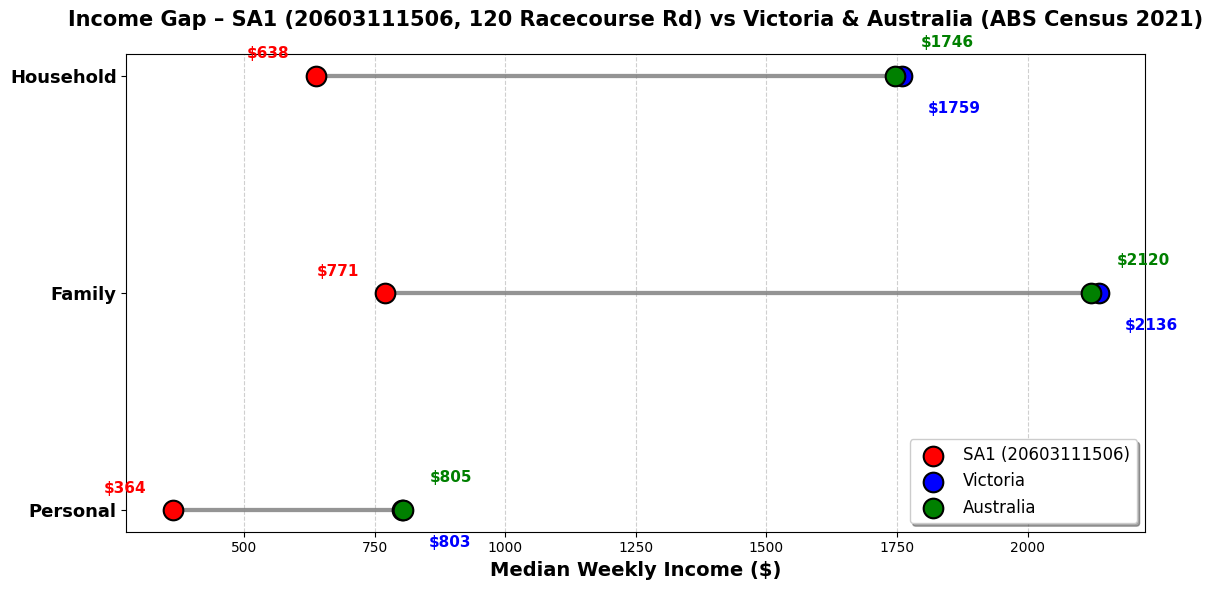

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ["Personal", "Family", "Household"]
sa1 = [364, 771, 638]
vic = [803, 2136, 1759]
aus = [805, 2120, 1746]

# Y positions
y_pos = range(len(categories))

plt.figure(figsize=(12, 6))

# Plot dumbbell lines (thicker & darker)
for i, cat in enumerate(categories):
    plt.plot([sa1[i], vic[i]], [i, i], color="gray", linewidth=3, alpha=0.6)
    plt.plot([sa1[i], aus[i]], [i, i], color="gray", linewidth=3, alpha=0.6)

# Plot points with bigger markers
plt.scatter(sa1, y_pos, color="red", s=200, label="SA1 (20603111506)", zorder=3, edgecolor="black", linewidth=1.5)
plt.scatter(vic, y_pos, color="blue", s=200, label="Victoria", zorder=3, edgecolor="black", linewidth=1.5)
plt.scatter(aus, y_pos, color="green", s=200, label="Australia", zorder=3, edgecolor="black", linewidth=1.5)

# Add labels for values
for i, (s, v, a) in enumerate(zip(sa1, vic, aus)):
    plt.text(s-50, i+0.1, f"${s}", ha="right", va="center", fontsize=11, fontweight="bold", color="red")
    plt.text(v+50, i-0.15, f"${v}", ha="left", va="center", fontsize=11, fontweight="bold", color="blue")
    plt.text(a+50, i+0.15, f"${a}", ha="left", va="center", fontsize=11, fontweight="bold", color="green")

# Formatting
plt.yticks(y_pos, categories, fontsize=13, fontweight="bold")
plt.xlabel("Median Weekly Income ($)", fontsize=14, fontweight="bold")
plt.title("Income Gap – SA1 (20603111506, 120 Racecourse Rd) vs Victoria & Australia (ABS Census 2021)",
          fontsize=15, fontweight="bold", pad=20)
plt.legend(fontsize=12, loc="lower right", frameon=True, shadow=True)

plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


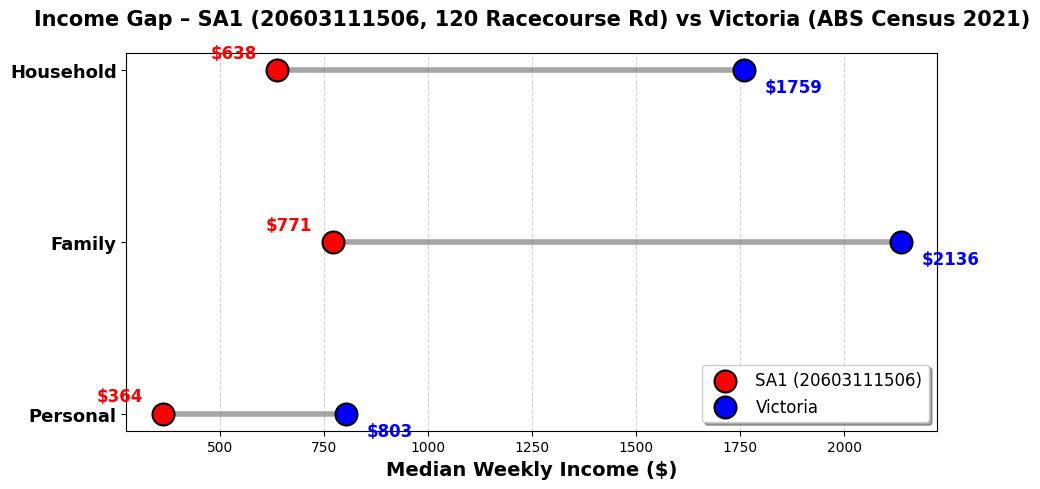

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ["Personal", "Family", "Household"]
sa1 = [364, 771, 638]
vic = [803, 2136, 1759]

# Y positions
y_pos = range(len(categories))

plt.figure(figsize=(10, 5))

# Plot dumbbell lines (SA1 → Victoria only)
for i, cat in enumerate(categories):
    plt.plot([sa1[i], vic[i]], [i, i], color="gray", linewidth=4, alpha=0.7)

# Plot points with larger markers
plt.scatter(sa1, y_pos, color="red", s=250, label="SA1 (20603111506)", zorder=3, edgecolor="black", linewidth=1.5)
plt.scatter(vic, y_pos, color="blue", s=250, label="Victoria", zorder=3, edgecolor="black", linewidth=1.5)

# Add text labels for values
for i, (s, v) in enumerate(zip(sa1, vic)):
    plt.text(s-50, i+0.1, f"${s}", ha="right", va="center", fontsize=12, fontweight="bold", color="red")
    plt.text(v+50, i-0.1, f"${v}", ha="left", va="center", fontsize=12, fontweight="bold", color="blue")

# Formatting
plt.yticks(y_pos, categories, fontsize=13, fontweight="bold")
plt.xlabel("Median Weekly Income ($)", fontsize=14, fontweight="bold")
plt.title("Income Gap – SA1 (20603111506, 120 Racecourse Rd) vs Victoria (ABS Census 2021)",
          fontsize=15, fontweight="bold", pad=20)
plt.legend(fontsize=12, loc="lower right", frameon=True, shadow=True)

plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


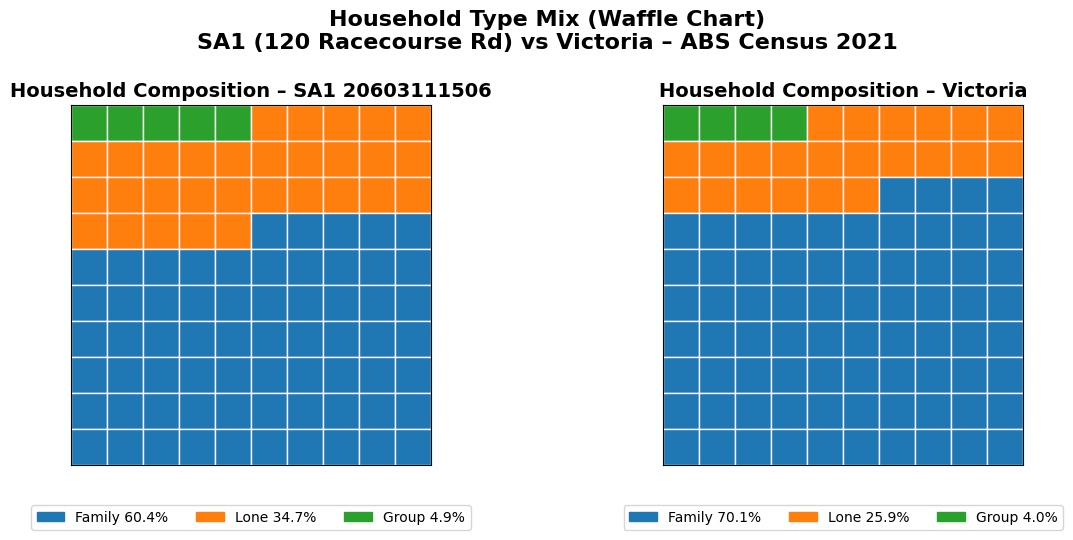

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Data for SA1 20603111506 (120 Racecourse Rd)
sa1_households = {
    "Family": 60.4,
    "Lone": 34.7,
    "Group": 4.9
}

# Data for Victoria (for context)
vic_households = {
    "Family": 70.1,
    "Lone": 25.9,
    "Group": 4.0
}

# Function to build waffle chart
def make_waffle(data, title, colors, ax):
    total = 100
    # Scale percentages to 100 cells
    counts = {k: int(round(v)) for k, v in data.items()}
    # Ensure total = 100
    diff = total - sum(counts.values())
    if diff != 0:
        # adjust largest category
        max_cat = max(counts, key=counts.get)
        counts[max_cat] += diff

    # Create grid
    grid = np.zeros((10, 10))
    category_index = 0
    for cat, count in counts.items():
        for i in range(count):
            row = i // 10
            col = i % 10
            grid[row, col] = category_index
        category_index += 1

    # Plot grid
    for r in range(10):
        for c in range(10):
            cat_index = int(grid[r, c])
            cat_name = list(counts.keys())[cat_index]
            ax.add_patch(plt.Rectangle([c, 9-r], 1, 1, facecolor=colors[cat_name], edgecolor="white"))

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    ax.set_title(title, fontsize=14, fontweight="bold")

    # Legend
    patches = [mpatches.Patch(color=colors[k], label=f"{k} {data[k]}%") for k in data.keys()]
    ax.legend(handles=patches, loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=10)

# Colors
colors = {
    "Family": "#1f77b4",
    "Lone": "#ff7f0e",
    "Group": "#2ca02c"
}

# Create figure with two waffle charts: SA1 and VIC
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

make_waffle(sa1_households, "Household Composition – SA1 20603111506", colors, axes[0])
make_waffle(vic_households, "Household Composition – Victoria", colors, axes[1])

fig.suptitle("Household Type Mix (Waffle Chart)\nSA1 (120 Racecourse Rd) vs Victoria – ABS Census 2021", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0,0.1,1,0.95])
plt.show()


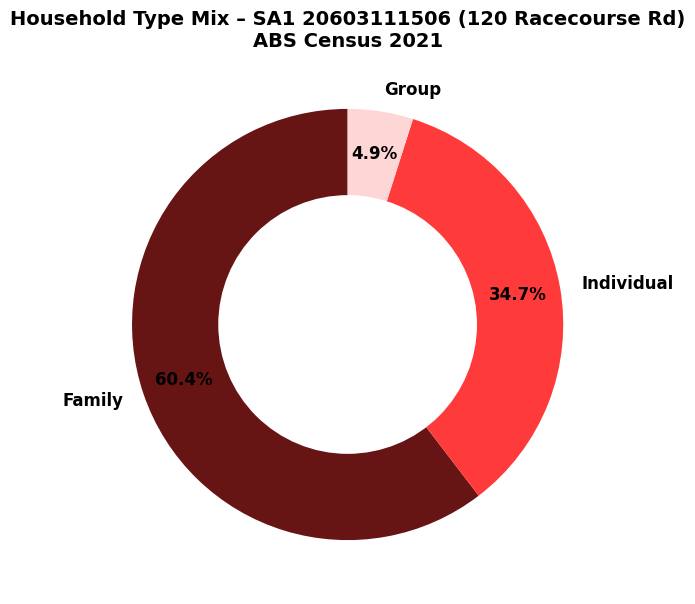

In [ ]:
import matplotlib.pyplot as plt

# Data for SA1 20603111506
labels = ['Family', 'Individual', 'Group']
sizes = [60.4, 34.7, 4.9]
colors = ['#661414', '#ff3a3a', '#ffd6d6']

# Create donut chart
fig, ax = plt.subplots(figsize=(7,7))
wedges, texts, autotexts = ax.pie(
    sizes, labels=labels, colors=colors, autopct='%1.1f%%',
    startangle=90, pctdistance=0.8, textprops={'fontsize': 12, 'weight': 'bold'}
)

# Draw a circle in the center to make it a donut
centre_circle = plt.Circle((0,0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

# Title
plt.title(
    "Household Type Mix – SA1 20603111506 (120 Racecourse Rd)\nABS Census 2021",
    fontsize=14, fontweight='bold'
)

plt.show()
